In [1]:
!pip install datasets pandas numpy scipy scikit-learn matplotlib seaborn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datasets import load_dataset
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')



In [3]:
SEED = 42
Z_THRESHOLD = 3
np.random.seed(SEED)


In [4]:
dataset = load_dataset("gvlassis/california_housing")
df = dataset["train"].to_pandas()

print(f"Размер датасета: {df.shape}")
print(f"Столбцы: {list(df.columns)}")

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"\nЧисловые признаки ({len(numerical_cols)}):")
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i}. {col}")

print("\nОписательная статистика:")
df.describe()

Размер датасета: (16640, 9)
Столбцы: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

Числовые признаки (9):
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveBedrms
  5. Population
  6. AveOccup
  7. Latitude
  8. Longitude
  9. MedHouseVal

Описательная статистика:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000
mean,3.797641,29.221995,5.396218,1.101687,1436.939123,3.007617,35.267714,-119.146628,2.018484
std,1.867145,12.797845,2.648682,0.511507,1159.762831,5.114548,2.086404,1.923576,1.132658
min,0.499900,1.000000,0.846154,0.375000,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.526300,19.000000,4.379310,1.007401,792.000000,2.425249,33.870000,-121.240000,1.183000
50%,3.474500,30.000000,5.166053,1.050725,1168.000000,2.831033,34.100000,-118.300000,1.736000
75%,4.635475,38.000000,6.000000,1.101127,1727.000000,3.309981,37.710000,-117.890000,2.530250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,599.714286,41.950000,-114.310000,5.000010


In [5]:
def clean_outliers_iqr(df, columns):
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)
        
        outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        if outliers_count > 0:
            print(f"Признак '{col}': обработано {outliers_count} выбросов")
    
    return df_clean

feature_cols = [col for col in numerical_cols if col != 'MedHouseVal']
print("Очистка данных от выбросов методом IQR")
df_cleaned = clean_outliers_iqr(df, feature_cols)
print(f"\nОчистка завершена. Размер датасета: {df_cleaned.shape}")

Очистка данных от выбросов методом IQR
Признак 'MedInc': обработано 591 выбросов
Признак 'AveRooms': обработано 436 выбросов
Признак 'AveBedrms': обработано 1190 выбросов
Признак 'Population': обработано 1007 выбросов
Признак 'AveOccup': обработано 537 выбросов

Очистка завершена. Размер датасета: (16640, 9)


In [6]:
print("\nАнализ выбросов (метод Z-Score)")
for col in feature_cols:
    z_scores = np.abs(stats.zscore(df[col]))
    outliers_count = (z_scores > Z_THRESHOLD).sum()
    if outliers_count > 0:
        print(f"Признак '{col}': {outliers_count} выбросов (Z-Score > {Z_THRESHOLD})")


Анализ выбросов (метод Z-Score)
Признак 'MedInc': 268 выбросов (Z-Score > 3)
Признак 'AveRooms': 118 выбросов (Z-Score > 3)
Признак 'AveBedrms': 122 выбросов (Z-Score > 3)
Признак 'Population': 270 выбросов (Z-Score > 3)
Признак 'AveOccup': 10 выбросов (Z-Score > 3)
Признак 'Latitude': 21 выбросов (Z-Score > 3)


In [7]:

X = df_cleaned[feature_cols]
y = df_cleaned['MedHouseVal']

print(f"Исходное количество признаков: {X.shape[1]}")

estimator = LinearRegression()

sfs = SequentialFeatureSelector(
    estimator,
    n_features_to_select='auto',
    direction='forward',
    scoring='neg_mean_squared_error',
    cv=3, 
    n_jobs=-1
)

print("Запуск отбора признаков (Жадный алгоритм)")
sfs.fit(X, y)

selected_features = [feature_cols[i] for i in range(len(feature_cols)) if sfs.get_support()[i]]
print(f"\nВыбрано признаков: {len(selected_features)}")
print("Выбранные признаки:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")

X_full = X
X_selected = X[selected_features]

model_full = LinearRegression().fit(X_full, y)
model_selected = LinearRegression().fit(X_selected, y)

mse_full = mean_squared_error(y, model_full.predict(X_full))
mse_selected = mean_squared_error(y, model_selected.predict(X_selected))

print(f"\nСравнение моделей:")
print(f"  Полная модель: MSE = {mse_full:.4f}")
print(f"  Отобранная модель ({len(selected_features)} признаков): MSE = {mse_selected:.4f}")
print(f"  Разница в MSE: {abs(mse_full - mse_selected):.4f}")

Исходное количество признаков: 8
Запуск отбора признаков (Жадный алгоритм)

Выбрано признаков: 4
Выбранные признаки:
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveOccup

Сравнение моделей:
  Полная модель: MSE = 0.4516
  Отобранная модель (4 признаков): MSE = 0.5425
  Разница в MSE: 0.0909


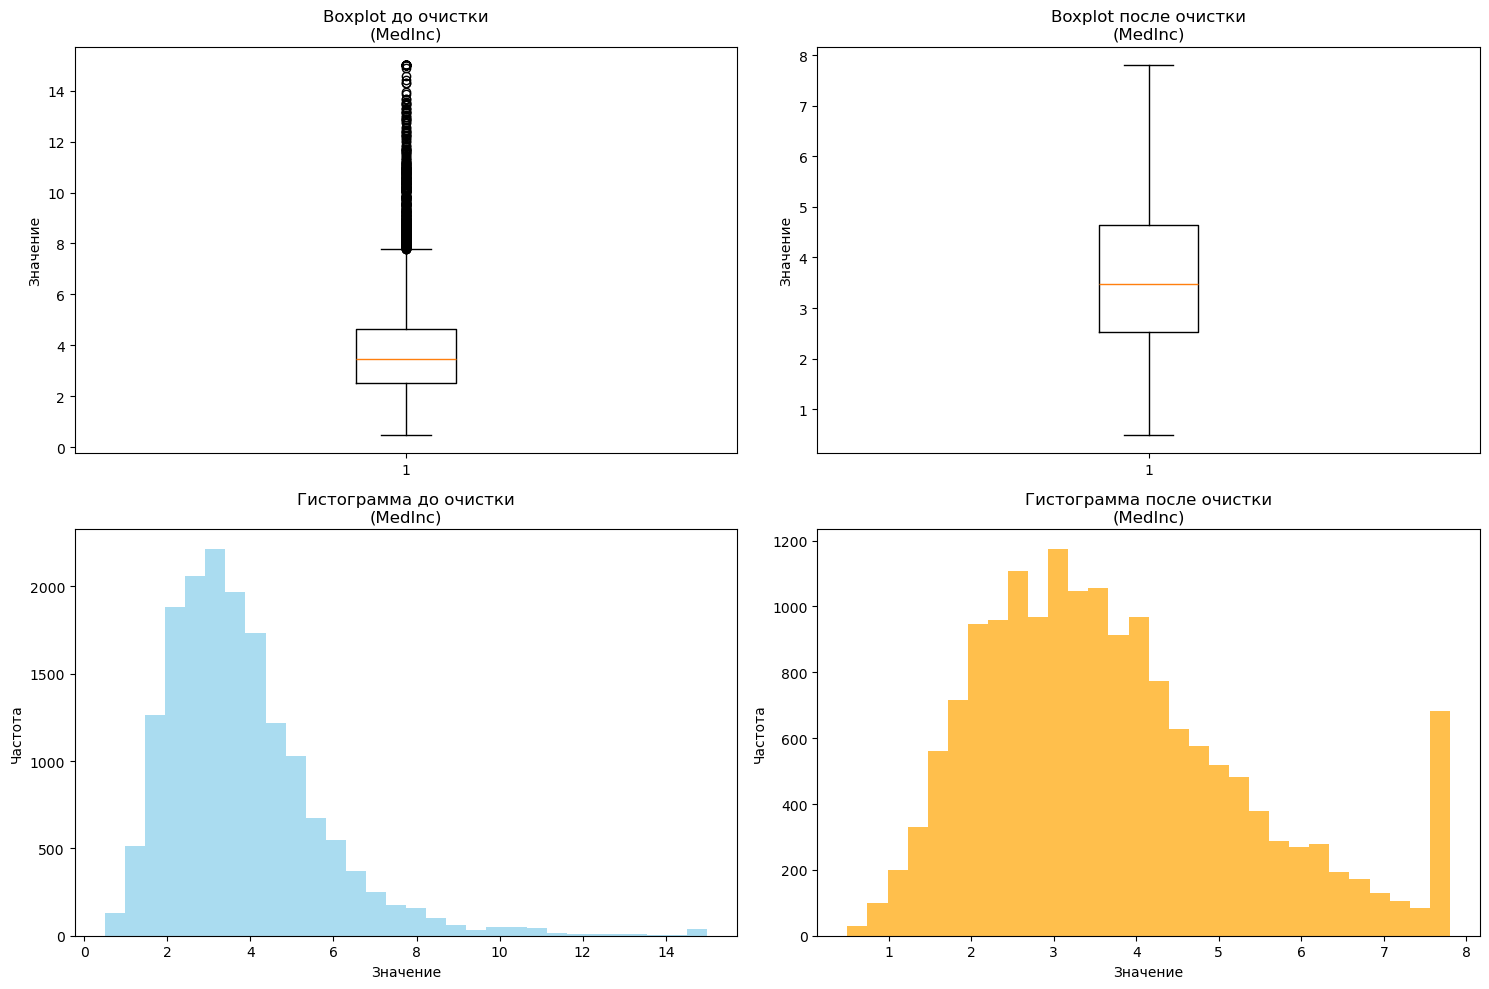

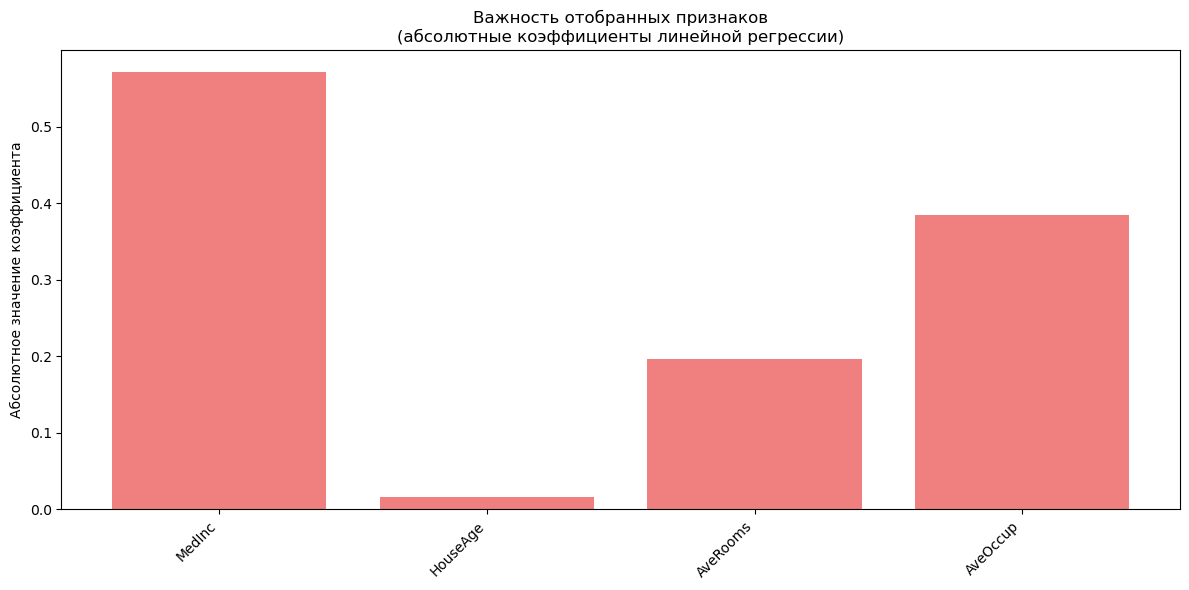

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sample_feature = 'MedInc'

axes[0, 0].boxplot(df[sample_feature])
axes[0, 0].set_title(f'Boxplot до очистки\n({sample_feature})')
axes[0, 0].set_ylabel('Значение')

axes[0, 1].boxplot(df_cleaned[sample_feature])
axes[0, 1].set_title(f'Boxplot после очистки\n({sample_feature})')
axes[0, 1].set_ylabel('Значение')

axes[1, 0].hist(df[sample_feature], bins=30, alpha=0.7, color='skyblue')
axes[1, 0].set_title(f'Гистограмма до очистки\n({sample_feature})')
axes[1, 0].set_xlabel('Значение')
axes[1, 0].set_ylabel('Частота')

axes[1, 1].hist(df_cleaned[sample_feature], bins=30, alpha=0.7, color='orange')
axes[1, 1].set_title(f'Гистограмма после очистки\n({sample_feature})')
axes[1, 1].set_xlabel('Значение')
axes[1, 1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
coefficients = [abs(model_selected.coef_[i]) for i in range(len(selected_features))]
bars = plt.bar(range(len(selected_features)), coefficients, color='lightcoral')
plt.xticks(range(len(selected_features)), selected_features, rotation=45, ha='right')
plt.title('Важность отобранных признаков\n(абсолютные коэффициенты линейной регрессии)')
plt.ylabel('Абсолютное значение коэффициента')
plt.tight_layout()
plt.show()

In [9]:

df_final = df_cleaned[selected_features + ['MedHouseVal']].copy()

print("Финальный датасет")
print(f"Размер: {df_final.shape}")
print(f"Признаки: {list(df_final.columns[:-1])}")
print(f"Целевая переменная: {df_final.columns[-1]}")

print("\nПервые 5 строк:")
df_final.head()

print("\nОписательная статистика финального датасета:")
df_final.describe()

Финальный датасет
Размер: (16640, 5)
Признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup']
Целевая переменная: MedHouseVal

Первые 5 строк:

Описательная статистика финального датасета:


,MedInc,HouseAge,AveRooms,AveOccup,MedHouseVal
count,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000
mean,3.725837,29.221995,5.254555,2.912586,2.018484
std,1.617481,12.797845,1.256372,0.714709,1.132658
min,0.499900,1.000000,1.948276,1.098151,0.149990
25%,2.526300,19.000000,4.379310,2.425249,1.183000
50%,3.474500,30.000000,5.166053,2.831033,1.736000
75%,4.635475,38.000000,6.000000,3.309981,2.530250
max,7.799237,52.000000,8.431034,4.637078,5.000010
